# Binomial setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import json
from statsmodels.graphics.tsaplots import plot_acf
from math import exp, log

In [16]:
def print_config(data):
        if not isinstance(data, list):
            for k, v in data.items():
                if k != 'posteriors':
                    print("{} => {}".format(k, v))
def extract_binom_from_file(path, from_abc=False):
    with open(path, 'r') as input_file:
        data = json.load(input_file)
        
    if not isinstance(data, list):
        print_config(data)
        data = data['posteriors'][:1002000]
        print(len(data))

    if from_abc:
        params = [d[0] for d in data]
        data_frame = pd.DataFrame({r'$\theta$': params})
    else:
        params = [d[1] for d in data]
        data_frame = pd.DataFrame({r'$\theta$': [p_to_theta(t) for t in params]})

    return data_frame

def theta_to_p(theta):
    return exp(theta)/(1 + exp(theta))

def p_to_theta(p):
    return log(p /(1 - p))

def summary(data, burn_in=0, by=1):
    col_names = data.columns.values
    for i in [10,25,50,75,95]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.around(np.percentile(data[param_name].tolist()[burn_in::by], i), decimals=3)
            print("Q{} for {} parameter {}".format(i, param_name, q))
    print("========== mean ==========")
    for _, param_name in np.ndenumerate(col_names):
        mean = np.around(np.mean(data[param_name].tolist()[burn_in::by]), decimals=3)
        print("mean for {} parameter {}".format(param_name, mean))


def plot_marginals(data, perfect_vals, burn_in=0, by=1):
    
    col_names = data.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,7*len(col_names)))
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
    
        if len(col_names) > 1:
            ax= axs[i,:]
        else:
            ax=axs
        params = data[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=ax[0])
        ax[0].axvline(perfect_vals[i], color='r', linestyle='--', label='expected value')

        # Path
        ax[1].plot(range(len(params)), params)
        ax[1].axhline(perfect_vals[i], color='r', linestyle='--', label='expected value')
        ax[1].set(xlabel='iterations', ylabel='{} parameter ABC'.format(param_name))


def comparaison_path_binom(data_mh, data_abc, burn_in=0, by=1):
    fig, axs = plt.subplots(1, 2, figsize=(14,7))
    params_abc = data_abc[r'$\theta$'].tolist()[burn_in::by]
    params_mh = data_mh[r'$\theta$'].tolist()[burn_in::by]
    axs[0].plot(range(len(params_abc)), params_abc)
    axs[0].set(xlabel='iterations', ylabel=r'$\theta$ parameter ABC')
    axs[0].set_title(label=r'ABC Algorithm - $\theta$')

    axs[1].plot(range(len(params_mh)), params_mh)
    axs[1].set(xlabel='iterations', ylabel=r'$\theta$ parameter MH')
    axs[1].set_title(label=r'MH Algorithm - $\theta$')

def comparaison(data_mh, data_abc, burn_in=0, by=1):
    col_names = data_mh.columns.values

    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,7*len(col_names)))
    
    for idx, param_name in np.ndenumerate(col_names):
    
        i = idx[0]
        # Sample parameter
        if len(col_names) > 1:
            ax= axs[i,:]
        else:
            ax=axs
        params_abc = data_abc[param_name].tolist()[burn_in::by]
        params_mh = data_mh[param_name].tolist()[burn_in::by]
        print(len(params_abc))
        print(len(params_mh))
        df = pd.DataFrame({"MH - {}".format(param_name): params_mh, "ABC - {}".format(param_name): params_abc})
        ax[0].set_title(label="Distribution - {}".format(param_name))
        sns.boxplot(data=df, ax=ax[0])
    
        ax[1].scatter(sorted(params_mh), sorted(params_abc))
        min_r = min(min(params_mh), min(params_abc))
        max_r = max(max(params_mh), max(params_abc))
        ax[1].plot([min_r,max_r], [min_r, max_r], color='r')
        ax[1].set_xlabel("Metropolis Hastings")
        ax[1].set_ylabel("ABC Algorithm")
        ax[1].set_title(label="QQ plot - {}".format(param_name))

def autocor(data_abc, burn_in=0, by=1):

    col_names = data_abc.columns.values
    fig, axs = plt.subplots(len(col_names), 1, sharex='col', sharey='row', figsize=(14,7*len(col_names))) 
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        
        if len(col_names) > 1:
            ax= axs[i]
        else:
            ax=axs
        params = data_abc[param_name].tolist()[burn_in::by]
    
        plot_acf(params, ax=ax)
        ax.set_title("Autocorrelation for {} parameter".format(param_name))

def MAP_computation(data_abc, burn_in=0, by=1):
    col_names = data_abc.columns.values
    map_vec = list()
    for idx, col_name in np.ndenumerate(col_names):
        i = idx[0]
        p=sns.kdeplot(data_abc[col_name][burn_in::by], shade=True)
        x = p.lines[i].get_xdata()
        y = p.lines[i].get_ydata()
        max_theta = np.around(x[np.argmax(y)], decimals=4)
        map_vec.append(max_theta)
    return map_vec

def paper_plot(data_mh, data_abc, burn_in=0, by=1):
    col_names = data_mh.columns.values

    fig, axs = plt.subplots(len(col_names), 4, figsize=(28,7*len(col_names)))
    
    for idx, param_name in np.ndenumerate(col_names):
    
        i = idx[0]
        # Sample parameter
        if len(col_names) > 1:
            ax= axs[i,:]
        else:
            ax=axs
        params_abc = data_abc[param_name].tolist()[burn_in::by]
        params_mh = data_mh[param_name].tolist()[burn_in::by]
        df = pd.DataFrame({"MH - {}".format(param_name): params_mh, "ABC - {}".format(param_name): params_abc})
        ax[0].set_title(label="Distribution - {}".format(param_name), fontsize=20)
        sns.boxplot(data=df, ax=ax[0])
        #plt.setp(ax.get_legend().get_texts(), fontsize='22')
        ax[0].tick_params(axis="x", labelsize=18)
        ax[1].scatter(sorted(params_mh), sorted(params_abc))
        min_r = min(min(params_mh), min(params_abc))
        max_r = max(max(params_mh), max(params_abc))
        ax[1].plot([min_r,max_r], [min_r, max_r], color='r')
        ax[1].set_xlabel("Metropolis Hastings", fontsize=18)
        ax[1].set_ylabel("ABC Algorithm", fontsize=18)
        ax[1].set_title(label="QQ plot - {}".format(param_name), fontsize=20)
    
    params_abc = data_abc[r'$\theta$'].tolist()[burn_in::by]
    params_mh = data_mh[r'$\theta$'].tolist()[burn_in::by]
    axs[2].plot(range(len(params_abc)), params_abc)
    axs[2].set_xlabel("iterations", fontsize=18)
    axs[2].set_ylabel(r'$\theta$ parameter', fontsize=18)
    #axs[2].set(xlabel='iterations', ylabel=r'$\theta$ parameter', fontsize=15)
    axs[2].set_title(label=r'ABC Algorithm - $\theta$', fontsize=20)

    axs[3].plot(range(len(params_mh)), params_mh)
    axs[3].set_xlabel("iterations", fontsize=18)
    axs[3].set_title(label=r'MH Algorithm - $\theta$', fontsize=20)

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R error.stat.area = function(name.file,data.est){
    # ... reading the file of sufficient statistics
    data.area = read.table(name.file,header=F)

    # ... burning-in : drop-on the first values,
    # if exact simulation is used there is no need for burning-in ...
    pos=seq(from=1,nrow(data.area),1)

    nsamples=length(pos);
    theta=data.area[pos,1]
    
    mntheta=cumsum(theta)/(1:nsamples)


    esp.stat=c(mean(theta))
    #print(esp.stat)
    grad=data.est[1:1]-esp.stat

    mat1=matrix(esp.stat,nrow=1,ncol=1)
    mat2=mat1%*%t(mat1)
  
    mat3=matrix(0,nrow=1,ncol=1)

    for(i in 1 : nsamples)
    {
        stat.temp = c(theta[i])
        temp=matrix(stat.temp,nrow=1,ncol=1)
        mat.temp=temp%*%t(temp)
        mat3=mat3+mat.temp
    }
    mat3=(1/nsamples)*mat3
    #print(mat3)
    hess=-(mat3-mat2)
    b1=solve(-hess)

   
   
    z1=data.est[1]-theta
    z4=c(cor(z1,z1))
    a1=matrix(z4,nrow=1,ncol=1)

    c1=(1/sqrt(nsamples))*b1%*%a1%*%b1

    list(gradient=grad,hessien=hess,B1=b1,C1=c1)
}

## Posterior Approximation for a Binomial model

Let the probability density function for binomial distribution: $P(y | n, p) = {n \choose y} p^{y}(1-p)^{(n-y)} $

Where $n$ is the **number of trials**, p **probability of success** and $y$ the **number of successes in $n$ trials**.

We can express this probability density function as an exponential model :

$P(y | n, \theta) = exp[y \theta - n log(1 + e^{\theta}) + log{n \choose y}] $

And then express the posterior distribution of $\theta$ for a Binomial model:

$P(\theta | y, n) \propto P(y | n, \theta) p(\theta) = exp[y \theta - n log(1 + e^{\theta}) + log{n \choose y}] P(\theta)$


Where $\theta = log(\frac{p}{1 - p})$ and conversely $p = \frac{e^{\theta}}{1 + e^{\theta}}$ 


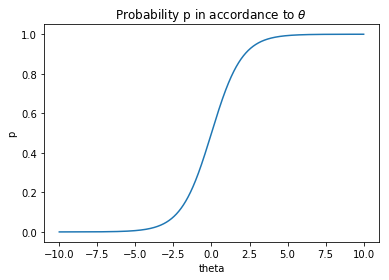

In [4]:
x = np.arange(-10,10, 0.001)
y = [exp(t)/(1 + exp(t)) for  t in x]
fig, ax = plt.subplots()
ax.set(xlabel='theta', ylabel='p',
       title=r'Probability p in accordance to $\theta$')
ax.plot(x,y)

In [19]:
FILE_NAME_ABC_BINOM = 'assets/binom/abc/binom_abc_1002000.json'
data_abc_binom = extract_binom_from_file(FILE_NAME_ABC_BINOM, from_abc=True)

algo => abc_shadow
model => binomial
theta0 => [-1.755079809390893]
theta_perf => [20.0, -0.405]
iters => 1000
n => 100
delta => [0.005]
y_obs => [8.0]
1002000


In [20]:
FILE_NAME_MH_BINOM = 'assets/binom/mh/binom_mh_1002000.json'
data_mh_binom = extract_binom_from_file(FILE_NAME_MH_BINOM)

algo => metropolis_hastings
model => binomial
theta0 => [20.0, 0.7310585786300049]
theta_perf => [20.0, 0.4001116311360017]
iters => 1002000
n => 100
delta => [0.005, 0.005]
y_obs => [8.0]
1002000


10000
10000


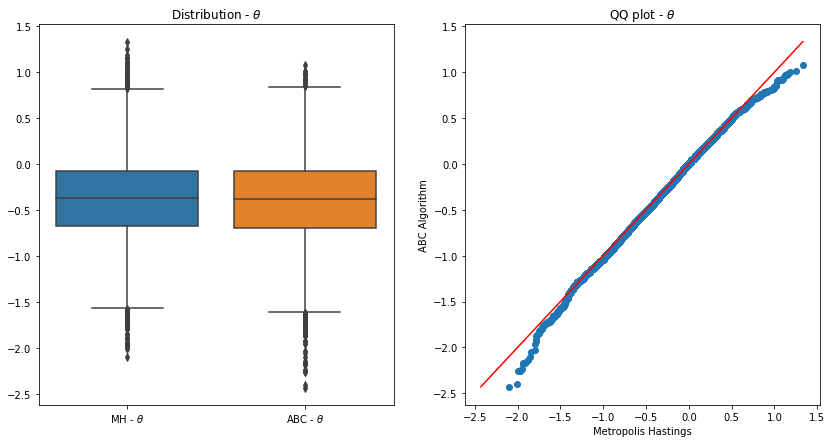

In [21]:
comparaison(data_mh_binom[::-1], data_abc_binom, burn_in=2000, by=100)
#plt.savefig("binomial_dist.pdf")

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[-0.408]

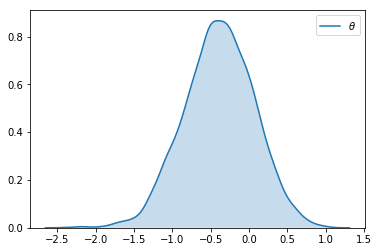

In [22]:
MAP_computation(data_abc_binom, burn_in=2000, by=100)

[-0.3718]

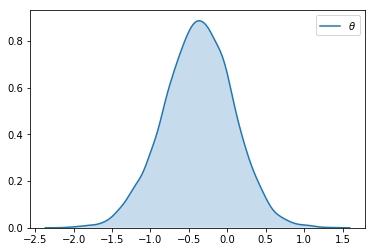

In [23]:
MAP_computation(data_mh_binom, burn_in=2000, by=100)

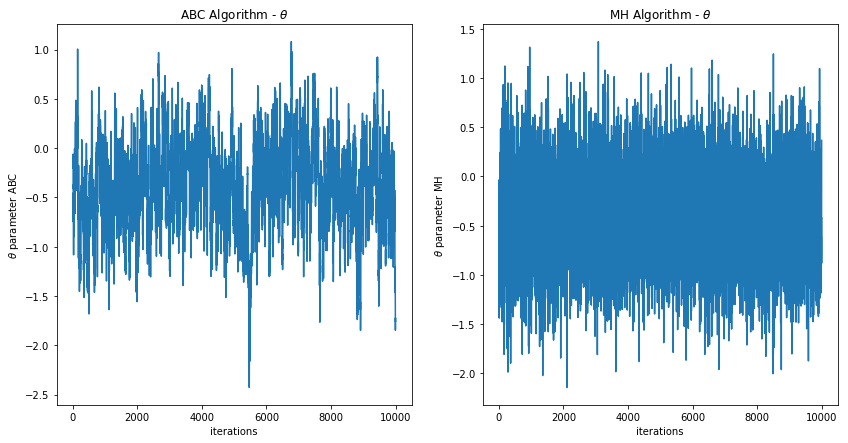

In [24]:
comparaison_path_binom(data_mh_binom, data_abc_binom, burn_in=2000, by= 100)
#plt.savefig("binomial_path.pdf")

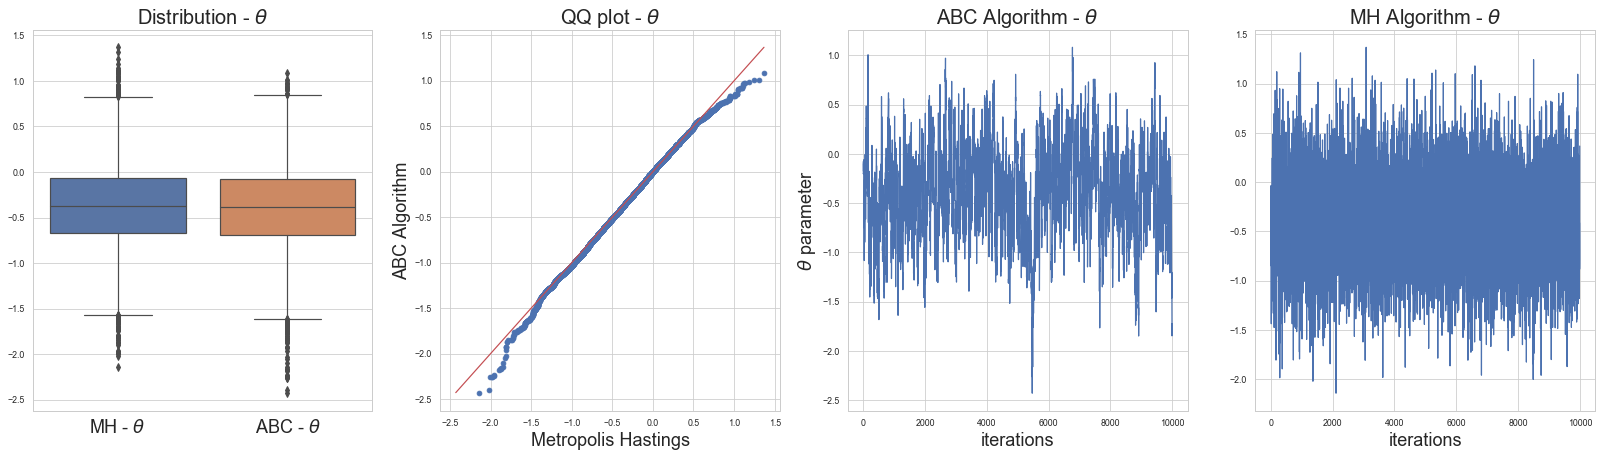

In [25]:
sns.set(font_scale=10)
sns.set_style("white")
sns.set_context("paper")
sns.set_style("whitegrid")
paper_plot(data_mh_binom, data_abc_binom, burn_in=2000, by=100)
plt.savefig("binomial_paper.pdf", bbox_inches='tight')

In [28]:
summary(data_abc_binom, by=100, burn_in=2000)

========== Q10 ==========
Q10 for $\theta$ parameter -0.992
========== Q25 ==========
Q25 for $\theta$ parameter -0.69
========== Q50 ==========
Q50 for $\theta$ parameter -0.383
========== Q75 ==========
Q75 for $\theta$ parameter -0.075
========== Q95 ==========
Q95 for $\theta$ parameter 0.345
========== mean ==========
mean for $\theta$ parameter -0.392


In [29]:
summary(data_mh_binom, by=100, burn_in=2000)

========== Q10 ==========
Q10 for $\theta$ parameter -0.961
========== Q25 ==========
Q25 for $\theta$ parameter -0.672
========== Q50 ==========
Q50 for $\theta$ parameter -0.371
========== Q75 ==========
Q75 for $\theta$ parameter -0.071
========== Q95 ==========
Q95 for $\theta$ parameter 0.353
========== mean ==========
mean for $\theta$ parameter -0.377


### New tries
> For the ABC Shadow the sampler iterates **100** times at each iteration of the Shadow Chain

In [6]:
NEW_FILE_NAME_MH_BINOM = 'metropolis_hastings-binomial-1574611186.3783257.json'
new_data_mh_binom = extract_binom_from_file(NEW_FILE_NAME_MH_BINOM)

algo => metropolis_hastings
model => binomial
theta0 => [20.0, 0.7310585786300049]
theta_perf => [20.0, 0.4001116311360017]
iters => 1000000
n => 100
delta => [0.005, 0.005]
y_obs => [8.0]


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


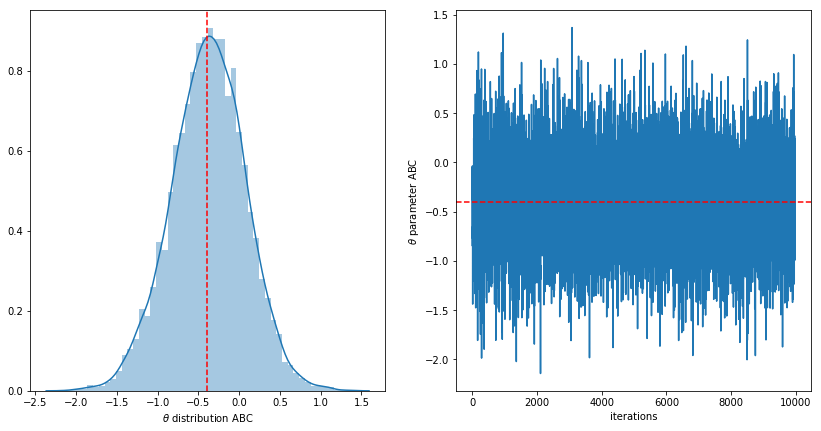

In [7]:
plot_marginals(new_data_mh_binom, [-0.4, 0.4], by=100,burn_in=2000)

[-0.3718]

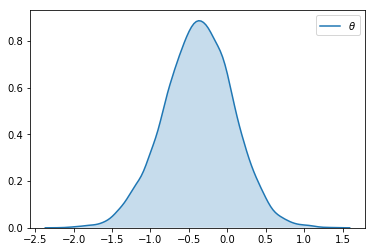

In [8]:
MAP_computation(new_data_mh_binom, burn_in=2000, by=100)

In [9]:
NEW_FILE_NAME_ABC_BINOM = 'abc_shadow-binomial-1574605753.2689676.json'
new_data_abc_binom = extract_binom_from_file(NEW_FILE_NAME_ABC_BINOM, from_abc=True)

algo => abc_shadow
model => binomial
theta0 => [-1.0201765655047803]
theta_perf => [20.0, -0.405]
iters => 10000
n => 100
delta => [0.005]
y_obs => [8.0]


$Burn-in = 2000$
Every $1$

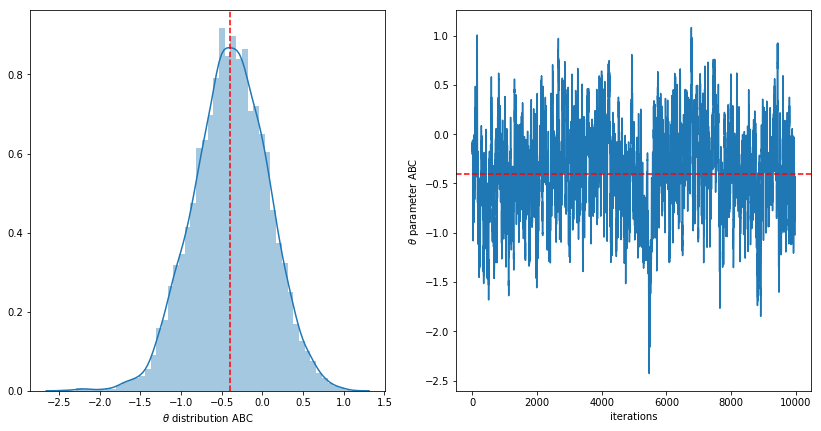

In [10]:
plot_marginals(new_data_abc_binom , [-0.4, 0.4], by=100,burn_in=2000)

[-0.408]

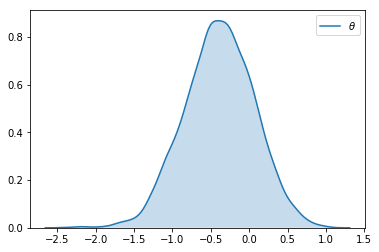

In [11]:
MAP_computation(new_data_abc_binom, burn_in=2000, by=100)

## Error metrics: ABC Shadow
> Chosen MAP =`[20, -0.408]`

In [11]:
%%R
res = error.stat.area("binom_post_MAP_ABC_1002000.txt", c(8))
print(res$grad)

print(sqrt(res$B1))
print(res$C1)

[1] -0.0023
          [,1]
[1,] 0.4543252
             [,1]
[1,] 0.0004260565


## Error metrics: Metropolis-Hastings
> Chosen MAP =`[20, -0.3718]`

In [4]:
%%R
res = error.stat.area("binom_post_MAP_MH_1002000.txt", c(8))
print(res$grad)
print(sqrt(res$B1))
print(res$C1)

[1] -0.1723
          [,1]
[1,] 0.4528173
             [,1]
[1,] 0.0004204286


In [7]:
%%R
res = error.stat.area("binom_post_MAP_ABC_1002000.txt", c(8))
print(res$grad)
print(sqrt(res$B1))
print(res$C1)

[1] -0.0023
          [,1]
[1,] 0.4543252
             [,1]
[1,] 0.0004260565


In [15]:
new_data_abc_binom.drop(new_data_abc_binom.tail(1).index,inplace=True)

NameError: name 'new_data_abc_binom' is not defined

In [14]:
comparaison(new_data_mh_binom, new_data_abc_binom, burn_in=2000, by=100)
plt.savefig("binomial_dist.pdf")

NameError: name 'new_data_mh_binom' is not defined

In [25]:
summary(new_data_abc_binom, burn_in=2000, by=100)

========== Q10 ==========
Q10 for $\theta$ parameter -0.986
========== Q25 ==========
Q25 for $\theta$ parameter -0.688
========== Q50 ==========
Q50 for $\theta$ parameter -0.382
========== Q75 ==========
Q75 for $\theta$ parameter -0.074
========== Q95 ==========
Q95 for $\theta$ parameter 0.346
========== mean ==========
mean for $\theta$ parameter -0.39


In [26]:
summary(new_data_mh_binom, burn_in=2000, by=100)

========== Q10 ==========
Q10 for $\theta$ parameter -0.961
========== Q25 ==========
Q25 for $\theta$ parameter -0.672
========== Q50 ==========
Q50 for $\theta$ parameter -0.37
========== Q75 ==========
Q75 for $\theta$ parameter -0.071
========== Q95 ==========
Q95 for $\theta$ parameter 0.353
========== mean ==========
mean for $\theta$ parameter -0.377
